#### How word2vec works:

- Take a 3 layer neural network. (1 input layer + 1 hidden layer + 1 output layer)
- Feed it a word and train it to predict its neighbouring word.
- Remove the last (output layer) and keep the input and hidden layer.
- Now, input a word from within the vocabulary. The output given at the hidden layer is the ‘word embedding’ of the input word.

In [1]:
import tensorflow as tf
import numpy as np

corpus_raw = 'He is the king . The king is royal . She is the royal  queen '

# convert to lower case
corpus_raw = corpus_raw.lower()

words = []
for word in corpus_raw.split():
    if word != '.': # because we don't want to treat . as a word
        words.append(word)

words = set(words) # so that all duplicate words are removed
word2int = {}
int2word = {}
vocab_size = len(words) # gives the total number of unique words
print('VOCAB SIZE:', vocab_size)

C:\Users\Hamburg\Anaconda3\envs\tensorflow2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


VOCAB SIZE: 7


We need to convert this to an **input output pair** such that if we input a word, it should it predict that the neighbouring words: the n words before and after it, where n is the parameter window_size

![](https://cdn-images-1.medium.com/max/800/1*yiH5sZI-IBxDSQMKhvbcHw.png)

Before doing this, we will create a dictionary which translates words to integers and integers to words. This will come in handy later.

Now, we will generate our training data:

In [2]:
for i,word in enumerate(words):
    word2int[word] = i
    int2word[i] = word

# raw sentences is a list of sentences.
raw_sentences = corpus_raw.split('.')
sentences = []
for sentence in raw_sentences:
    sentences.append(sentence.split())

WINDOW_SIZE = 2

data = []
for sentence in sentences:
    for word_index, word in enumerate(sentence):
        for nb_word in sentence[max(word_index - WINDOW_SIZE, 0) : min(word_index + WINDOW_SIZE, len(sentence)) + 1] : 
            if nb_word != word:
                data.append([word, nb_word])

In [3]:
### This basically gives a list of word, word pairs. (we are considering a window size of 2)
print(data)

[['he', 'is'], ['he', 'the'], ['is', 'he'], ['is', 'the'], ['is', 'king'], ['the', 'he'], ['the', 'is'], ['the', 'king'], ['king', 'is'], ['king', 'the'], ['the', 'king'], ['the', 'is'], ['king', 'the'], ['king', 'is'], ['king', 'royal'], ['is', 'the'], ['is', 'king'], ['is', 'royal'], ['royal', 'king'], ['royal', 'is'], ['she', 'is'], ['she', 'the'], ['is', 'she'], ['is', 'the'], ['is', 'royal'], ['the', 'she'], ['the', 'is'], ['the', 'royal'], ['the', 'queen'], ['royal', 'is'], ['royal', 'the'], ['royal', 'queen'], ['queen', 'the'], ['queen', 'royal']]


We have our training data. But it needs to be represented in a way a computer can understand i.e., with numbers. That’s where our word2int dict comes handy.

Let’s go one step further and convert these numbers into one hot vectors.

In [4]:
# function to convert numbers to one hot vectors
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

x_train = [] # input word
y_train = [] # output word

for data_word in data:
    x_train.append(to_one_hot(word2int[ data_word[0] ], vocab_size))
    y_train.append(to_one_hot(word2int[ data_word[1] ], vocab_size))

# convert them to numpy arrays
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

# making placeholders for x_train and y_train
x = tf.placeholder(tf.float32, shape=(None, vocab_size))
y_label = tf.placeholder(tf.float32, shape=(None, vocab_size))

#### Build the TF model
We take our training data and convert into the embedded representation.
![](https://cdn-images-1.medium.com/max/800/1*Os5hj9qg1t6sr0S3DF4gyA.jpeg)

Next, we take what we have in the embedded dimension and make a prediction about the neighbour. To make the prediction we use softmax.

![](https://cdn-images-1.medium.com/max/800/1*KxWiUoe-FXPpBdATP-IHOw.jpeg)

Putting it all together:

![](https://cdn-images-1.medium.com/max/800/1*cnzY08TWRxG3lMKExbslHw.jpeg)

In [5]:
EMBEDDING_DIM = 5 # you can choose your own number
W1 = tf.Variable(tf.random_normal([vocab_size, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([EMBEDDING_DIM])) #bias
hidden_representation = tf.add(tf.matmul(x,W1), b1)

W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, vocab_size]))
b2 = tf.Variable(tf.random_normal([vocab_size]))
prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_representation, W2), b2))


sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init) #make sure you do this!

# define the loss function:
cross_entropy_loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), reduction_indices=[1]))

# define the training step:
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy_loss)

n_iters = 10000
# train for n_iter iterations

for i in range(n_iters):
    sess.run(train_step, feed_dict={x: x_train, y_label: y_train})
    if i % 1000 == 0:
        print('loss is : ', sess.run(cross_entropy_loss, feed_dict={x: x_train, y_label: y_train}))

vectors = sess.run(W1 + b1)

loss is :  4.8655634
loss is :  1.3339634
loss is :  1.3245685
loss is :  1.322706
loss is :  1.3219552
loss is :  1.3215587
loss is :  1.3213165
loss is :  1.3211542
loss is :  1.3210388
loss is :  1.3209527


In [6]:
vectors

array([[ 0.1771315 ,  2.534896  ,  0.12048233, -1.0095664 , -2.4403453 ],
       [-0.52023643, -0.01538953,  0.9533155 ,  0.351808  , -2.6174932 ],
       [ 1.1300045 ,  1.4522036 ,  0.5414654 ,  0.25543743, -2.7471437 ],
       [ 1.2745713 , -2.3633327 ,  0.43501258, -0.474557  ,  0.09899104],
       [ 0.8381069 , -1.7494974 ,  0.91261697, -1.1692283 , -3.022526  ],
       [-0.7047902 , -0.95637536, -2.7814603 , -0.21022588, -1.3964595 ],
       [ 2.212988  ,  1.2685745 , -1.0206771 ,  0.19679004, -1.2459978 ]],
      dtype=float32)

#### Why one hot vectors?

![](https://cdn-images-1.medium.com/max/800/1*neaOXEbp6h6kgOKVsMwLhw.png)

When we multiply the one hot vectors with W1 , we basically get access to the row of the of W1 which is in fact the embedded representation of the word represented by the input one hot vector. So W1is essentially acting as a look up table.

Here’s a quick function to find the closest vector to a given vector. We will then query these vectors with ‘king’, ‘queen’ and ‘royal’

In [7]:
def euclidean_dist(vec1, vec2):
    return np.sqrt(np.sum((vec1-vec2)**2))

def find_closest(word_index, vectors):
    min_dist = 10000 # to act like positive infinity
    min_index = -1
    query_vector = vectors[word_index]
    for index, vector in enumerate(vectors):
        if euclidean_dist(vector, query_vector) < min_dist and not np.array_equal(vector, query_vector):
            min_dist = euclidean_dist(vector, query_vector)
            min_index = index
    return min_index


In [8]:
print(int2word[find_closest(word2int['king'], vectors)])
print(int2word[find_closest(word2int['queen'], vectors)])
print(int2word[find_closest(word2int['royal'], vectors)])

he
king
he


In [9]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
vectors = model.fit_transform(vectors) 

In [10]:
vectors

array([[  98.62437  ,  -46.910557 ],
       [  20.593395 ,  -66.47342  ],
       [ -35.364014 ,   -8.677956 ],
       [  76.550896 , -124.26881  ],
       [  42.666958 ,   10.884909 ],
       [ -57.437626 ,  -86.0362   ],
       [  -1.4801685, -143.83168  ]], dtype=float32)

In [11]:
from sklearn import preprocessing

normalizer = preprocessing.Normalizer()
vectors =  normalizer.fit_transform(vectors, 'l2')

print(vectors)

[[ 0.90305036 -0.42953476]
 [ 0.29592353 -0.9552116 ]
 [-0.97118694 -0.23831902]
 [ 0.524484   -0.8514204 ]
 [ 0.96896553  0.24719599]
 [-0.5552365  -0.8316925 ]
 [-0.01029043 -0.9999471 ]]


{'she', 'king', 'he', 'is', 'queen', 'the', 'royal'}
she -0.42953476
king -0.9552116
he -0.23831902
is -0.8514204
queen 0.24719599
the -0.8316925
royal -0.9999471


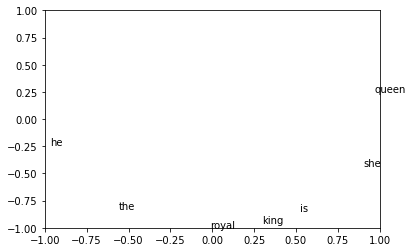

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
print(words)

for word in words:
    print(word, vectors[word2int[word]][1])
    ax.annotate(word, xy=(vectors[word2int[word]][0],vectors[word2int[word]][1] ))
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
plt.show()